In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
import os
import kaggle


# Set up Kaggle API credentials
download_path = '/tmp'
# Downloading the data
kaggle.api.dataset_download_files('paultimothymooney/chest-xray-pneumonia', path=download_path, unzip=True)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import shutil
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/tmp/chest_xray/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

dataset_path= '/tmp/chest_xray/'
new_dataset_path = '/tmp/chest_xray_new/'
if not os.path.exists(new_dataset_path):
   for split in ['train', 'val', 'test']:
       for cls in ['NORMAL', 'PNEUMONIA']:
           os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)

   for cls in ['NORMAL', 'PNEUMONIA']:
       all_files = []
       for split in ['train', 'val', 'test']:
           source_folder = f'{dataset_path}/{split}/{cls}'
           files = os.listdir(source_folder)
           all_files.extend([(file, source_folder) for file in files])

       random.shuffle(all_files)

       train_files = all_files[:int(len(all_files)*0.8)]
       val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
       test_files = all_files[int(len(all_files)*0.9):]

       for file, source_folder in train_files:
           dest = f'{new_dataset_path}/train/{cls}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest)

       for file, source_folder in val_files:
           dest = f'{new_dataset_path}/val/{cls}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest)

       for file, source_folder in test_files:
           dest = f'{new_dataset_path}/test/{cls}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest) 

In [2]:
input_shape = (224, 224, 3)

train_path =  '/tmp/chest_xray_new/train'
test_path =  '/tmp/chest_xray_new/test'
valid_path =  '/tmp/chest_xray_new/val'


In [3]:
inceptionV3=InceptionV3(input_shape = input_shape, # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet' )

In [4]:

# don't train existing weights
for layer in inceptionV3.layers:
    layer.trainable = False

In [5]:
# our layers - 
x = Flatten()(inceptionV3.output)

In [6]:
prediction = Dense(2, activation='softmax')(x)

In [7]:
model = Model(inputs=inceptionV3.input, outputs=prediction)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [9]:
from tensorflow.keras import callbacks, optimizers


checkpoint_callback = callbacks.ModelCheckpoint(filepath="tmp/best_model.keras", monitor='val_accuracy', save_best_only=True)

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5,mode='max', verbose=1 )

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 4684 images belonging to 2 classes.


In [12]:
valid_set = valid_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 587 images belonging to 2 classes.


In [13]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 585 images belonging to 2 classes.


In [14]:
import math
import numpy as np
batch_size=32

number_of_examples = len(test_set.filenames)
number_of_generator_calls = math.ceil(number_of_examples / batch_size)

test_labels = []

# Iterate through the generator calls
for i in range(0, int(number_of_generator_calls)):
    # Get the labels for the current batch
    batch_labels = np.array(test_set[i][1])
    test_labels.extend(batch_labels)
    


In [15]:
# fit the model

r = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=10,
 callbacks=[checkpoint_callback,early_stopping_callback]
)


Epoch 1/10
147/147 [==============================] - 98s 616ms/step - loss: 1.5093 - accuracy: 0.8721 - val_loss: 2.6243 - val_accuracy: 0.7819
Epoch 2/10
147/147 [==============================] - 95s 644ms/step - loss: 0.7961 - accuracy: 0.9159 - val_loss: 0.5501 - val_accuracy: 0.9438
Epoch 3/10
147/147 [==============================] - 131s 888ms/step - loss: 0.7228 - accuracy: 0.9302 - val_loss: 0.6709 - val_accuracy: 0.9267
Epoch 4/10
147/147 [==============================] - 136s 919ms/step - loss: 0.6388 - accuracy: 0.9304 - val_loss: 0.4451 - val_accuracy: 0.9557
Epoch 5/10
147/147 [==============================] - 138s 933ms/step - loss: 0.7930 - accuracy: 0.9268 - val_loss: 1.0621 - val_accuracy: 0.9114
Epoch 6/10
147/147 [==============================] - 138s 934ms/step - loss: 0.7253 - accuracy: 0.9327 - val_loss: 0.6001 - val_accuracy: 0.9455
Epoch 7/10
147/147 [==============================] - 138s 939ms/step - loss: 0.6213 - accuracy: 0.9368 - val_loss: 1.7923 - v

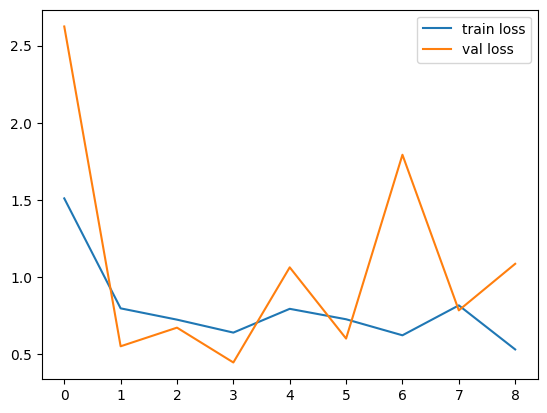

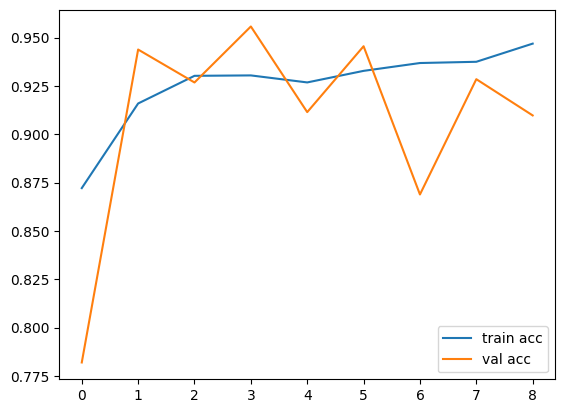

<Figure size 640x480 with 0 Axes>

In [16]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')

plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [17]:
test_loss, test_acc = model.evaluate(test_set)
print('Test accuracy:', test_acc)

19/19 [==============================] - 9s 442ms/step - loss: 1.2619 - accuracy: 0.8838
Test accuracy: 0.8837606906890869


In [18]:
from sklearn.metrics import classification_report


y_pred = model.predict(test_set)

print(classification_report(np.argmax(test_labels,axis=1), np.argmax(y_pred,axis=1)))

19/19 [==============================] - 7s 312ms/step
              precision    recall  f1-score   support

           0       0.26      0.35      0.30       158
           1       0.72      0.62      0.67       427

    accuracy                           0.55       585
   macro avg       0.49      0.49      0.48       585
weighted avg       0.60      0.55      0.57       585



In [20]:
import tensorflow as tf

from keras.models import load_model

model.save('model_InceptionV3.h5')

In [ ]:
def show_image(img_name):
  img = plt.imread(img_name)
  plt.imshow(img)
  plt.show()